# Move Set Graph Notebook for Cl(2)

This notebook explicitly builds the move set graph for the $n=2$ Clifford group.

In [1]:
## imports
from collections import Counter
import itertools
import numpy as np
from scipy.sparse import csr_array
import networkx as nx
import pandas as pd
import seaborn as sns
from qiskit.quantum_info import random_clifford, Clifford
from qiskit.synthesis import synth_clifford_full
from qiskit import Aer, execute, QuantumCircuit
import clifford as cl

In [2]:
## plotting imports and style set-up
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5.0
plt.rcParams["xtick.minor.size"] = 3.0
plt.rcParams["ytick.major.size"] = 5.0
plt.rcParams["ytick.minor.size"] = 3.0
plt.rc("font", family="serif", size=14)
# matplotlib.rc('text', usetex=True)
matplotlib.rc("legend", fontsize=14)
plt.rcParams["ytick.minor.size"] = 3.0
matplotlib.rcParams.update(
    {"axes.grid": True, "grid.alpha": 0.75, "grid.linewidth": 0.5}
)
matplotlib.rcParams["axes.prop_cycle"] = cycler(
    color=["#E24A33", "#348ABD", "#988ED5", "#777777", "#FBC15E", "#8EBA42", "#FFB5B8"]
)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

Build the graph representing the possible state changes for the move set. First, enumerate all valid tableaus for n=2. These will be the nodes.

In [3]:
states_indx = {}
states_bitstr = {}
i = 0
for seq in itertools.product("01", repeat=20):
    bitstr = "".join(seq)
    arr = cl.bitstr_to_array(bitstr, num_qubits=2)
    try:
        Clifford(cl.bitstr_to_array(bitstr, num_qubits=2))
        states_indx[i] = bitstr
        states_bitstr[bitstr] = i
        i += 1
    except:
        pass

print("number of states found: %i" % len(states_indx))

number of states found: 11520


Next, build the graph by adding edges for each move connecting nodes (i,j):

In [21]:
G = nx.Graph()

## loop over each state/node
for i in range(11520):
    bitstr = states_indx[i]
    problem = cl.Problem(2, initial_state=Clifford(cl.bitstr_to_array(bitstr, num_qubits=2)))

    ## loop over each possible move
    for move in problem.move_set:
        new_state = 1 * problem.apply_move(move).tableau.flatten()
        new_bitstr = cl.array_to_bitstr(new_state)
        i_new = states_bitstr[new_bitstr]
        # Adj[i, i_new] = 1
        #edge_list.append((i, i_new))
        
        # add the edge, SWAPs count as 3 CNOTs
        if move[-1] != 'swap':
            G.add_weighted_edges_from([(i, i_new, 1)])
        else:
            G.add_weighted_edges_from([(i, i_new, 3)])

In [23]:
## define the identity tableau
identity_tableau = cl.sequence_to_tableau([], problem.num_qubits).tableau.flatten()
i_identity = states_bitstr[cl.array_to_bitstr(1 * identity_tableau)]
cl.bitstr_to_array(states_indx[i_identity], num_qubits=2)

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]])

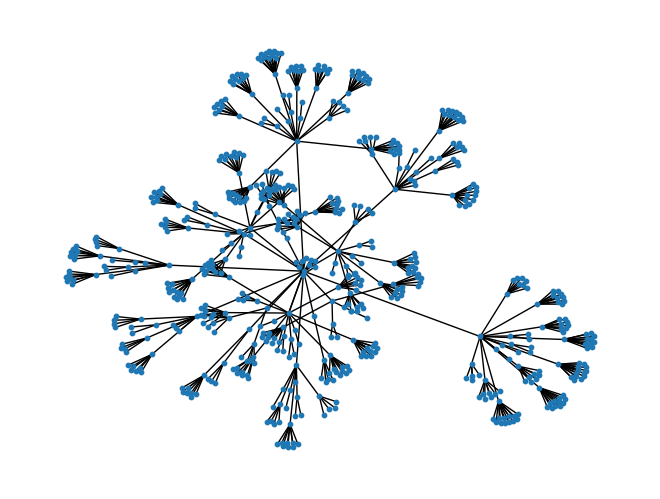

In [24]:
## plot a subgraph
Gsub = nx.from_edgelist(list(nx.bfs_edges(G, i_identity, reverse=False, depth_limit=3)))
nx.draw(Gsub, pos=nx.fruchterman_reingold_layout(Gsub), node_size=10)

In [25]:
## compute the degree distribution - this graph is d-regular
degree_sequence = np.asarray(sorted([d for n, d in G.degree()], reverse=False))
Counter(degree_sequence), len(problem.move_set)

(Counter({15: 11520}), 15)

In [26]:
## compute the God number and diameter
L_true = nx.single_source_shortest_path(G, i_identity)
god_number = max([len(L_true[key]) - 1 for key in L_true.keys()])
print("god number = %i" % god_number)
print("diameter = %i" % nx.diameter(G))

god number = 8
diameter = 8


`L_true` is a dictionary containing the path from the identity tableau/node to all other nodes. Let's look at a few examples:

In [27]:
for i, (key, value) in enumerate(L_true.items()):
    if i > 20:
        break
    print(f"start node={key}, path={value}")

start node=5440, path=[5440]
start node=896, path=[5440, 896]
start node=2432, path=[5440, 2432]
start node=5376, path=[5440, 5376]
start node=6976, path=[5440, 6976]
start node=7360, path=[5440, 7360]
start node=5444, path=[5440, 5444]
start node=5828, path=[5440, 5828]
start node=5824, path=[5440, 5824]
start node=8512, path=[5440, 8512]
start node=5632, path=[5440, 5632]
start node=5504, path=[5440, 5504]
start node=5536, path=[5440, 5536]
start node=5441, path=[5440, 5441]
start node=5473, path=[5440, 5473]
start node=5472, path=[5440, 5472]
start node=128, path=[5440, 896, 128]
start node=768, path=[5440, 896, 768]
start node=904, path=[5440, 896, 904]
start node=908, path=[5440, 896, 908]
start node=1280, path=[5440, 896, 1280]


Check that I can correctly convert a path in the graph into a sequence of moves. If I apply the sequence of moves in the proper order to the identity tableau, I should arrive at the destination node in the path. At the same time, count the number of CNOTs in each path.

In [28]:
def find_connecting_moves(problem, state_list):
    """
    Given a list of states, encoded as bit-string representations
    of the flattened tableau vectors, find the sequence of moves
    connecting the first state to the second, and then to the third,
    and so on. If the sequence of states does not represent a connected
    path, return None.
    """
    seq = []
    for i in range(len(state_list) - 1):
        indxA = state_list[::-1][i + 1]
        indxB = state_list[::-1][i]
        move = problem.find_move_from_a_to_b(
            Clifford(cl.bitstr_to_array(states_indx[indxA], num_qubits=2)),
            Clifford(cl.bitstr_to_array(states_indx[indxB], num_qubits=2)),
        )
        if move is not None:
            seq.append(move)
        else:
            return
    return seq[::-1]

In [29]:
## iterate over all paths starting at the identity
N_CNOT_true = {}
for destination_node, state_list in L_true.items():
    problem = cl.Problem(2, initial_state=Clifford(QuantumCircuit(2)))
    counter = 0

    ## treat identity node as a special case
    if len(state_list) == 1:
        N_CNOT_true[destination_node] = 0
    ## all other starting nodes
    else:
        seq = find_connecting_moves(problem, state_list)
        assert seq is not None
        for move in seq:
            assert move[-1] in ["x", "y", "z", "h", "s", "sdg", "cx", "swap"]
            problem.apply_move(move, inplace=True)
            if move[-1] == "cx":
                counter += 1
            elif move[-1] == "swap":
                counter += 3
        N_CNOT_true[destination_node] = counter

        ## check final state equals destination node
        assert problem.state == Clifford(
            cl.bitstr_to_array(states_indx[state_list[-1]], num_qubits=2)
        )

Do the same counting, but now for the sequence/path returned by the decomposition algorithm.

In [30]:
## CNOT counter
def CNOT_count(circ):
    op_counts = dict(circ.count_ops())
    return op_counts.get("cx", 0) + 3 * op_counts.get("swap", 0)


## initialize some dictionaries
L_decomp = {key: None for key in L_true.keys()}
L_delta = {key: None for key in L_true.keys()}
N_CNOT_decomp = {key: None for key in N_CNOT_true.keys()}
N_CNOT_delta = {key: None for key in N_CNOT_true.keys()}

## extract the seq lengths and CNOT counts given by the decomposition algorithm
for key, L_true_list in L_true.items():
    circ = Clifford(cl.bitstr_to_array(states_indx[key], num_qubits=2)).to_circuit()

    L_decomp[key] = sum(dict(circ.count_ops()).values())
    L_delta[key] = L_decomp[key] - (len(L_true_list) - 1)

    N_CNOT_decomp[key] = CNOT_count(circ)
    N_CNOT_delta[key] = N_CNOT_decomp[key] - N_CNOT_true[key]

    ## the delta should always be negative or zero
    if N_CNOT_delta[key] > 0:
        print("warning!")

Plot and compare

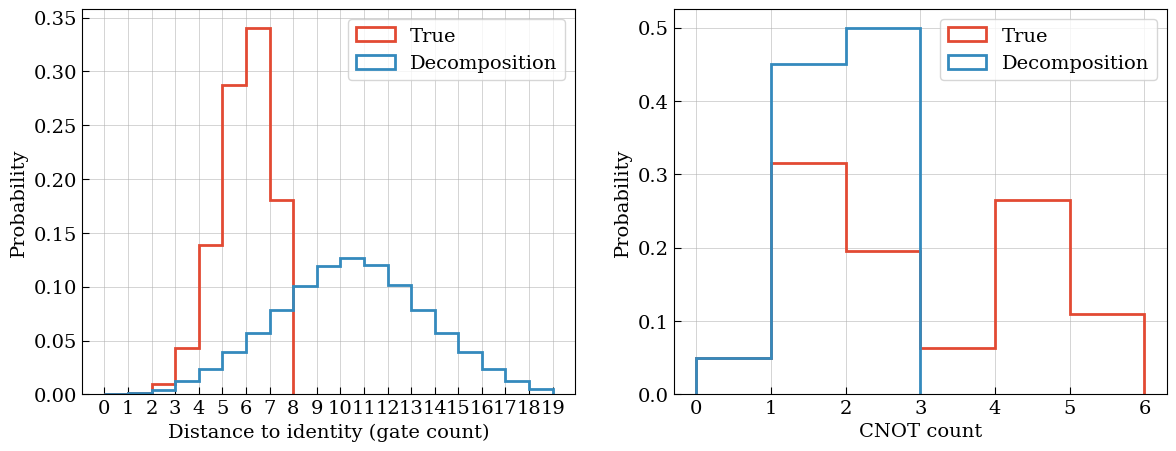

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 7, 5))

## distances
L_true_values = [len(value) - 1 for value in L_true.values()]
L_decomp_values = [value for value in L_decomp.values()]
_, bins, patches = ax[0].hist(
    L_true_values,
    np.max(L_true_values),
    density=True,
    alpha=1,
    histtype="step",
    linewidth=2,
    label="True",
)
_, bins, patches = ax[0].hist(
    L_decomp_values,
    np.max(L_decomp_values),
    density=True,
    alpha=1,
    histtype="step",
    linewidth=2,
    label="Decomposition",
)
ax[0].set_xticks(np.arange(0, max(L_decomp_values) + 1))
ax[0].legend()
ax[0].set_xlabel("Distance to identity (gate count)")
ax[0].set_ylabel("Probability")

## CNOTs
_, bins, patches = ax[1].hist(
    list(N_CNOT_true.values()),
    np.max(list(N_CNOT_true.values())),
    density=True,
    alpha=1,
    histtype="step",
    linewidth=2,
    label="True",
)
_, bins, patches = ax[1].hist(
    list(N_CNOT_decomp.values()),
    np.max(list(N_CNOT_decomp.values())),
    density=True,
    alpha=1,
    histtype="step",
    linewidth=2,
    label="Decomposition",
)
ax[1].set_xticks(np.arange(0, max(list(N_CNOT_true.values())) + 1))
ax[1].legend()
ax[1].set_xlabel("CNOT count")
ax[1].set_ylabel("Probability")

plt.show()

In [32]:
L_true_values = [len(value) - 1 for value in L_true.values()]
L_delta_values = [value for value in L_delta.values()]

print("max L_true = %i" % np.max(L_true_values))
print("min L_true = %i" % np.min(L_true_values))
print("max L_decomp = %i" % np.max(L_decomp_values))
print("min L_decomp = %i" % np.min(L_decomp_values))

max L_true = 8
min L_true = 0
max L_decomp = 19
min L_decomp = 0


In [33]:
N_CNOT_true_values = np.asarray([value for value in N_CNOT_true.values()])
N_CNOT_decomp_values = np.asarray([value for value in N_CNOT_decomp.values()])
N_CNOT_delta_values = np.asarray([value for value in N_CNOT_delta.values()])

print("max N_CNOT_true = %i" % np.max(N_CNOT_true_values))
print("min N_CNOT_true = %i" % np.min(N_CNOT_true_values))
print("max N_CNOT_delta = %i" % np.max(N_CNOT_delta_values))
print("min N_CNOT_delta = %i" % np.min(N_CNOT_delta_values))

max N_CNOT_true = 6
min N_CNOT_true = 0
max N_CNOT_delta = 0
min N_CNOT_delta = -5


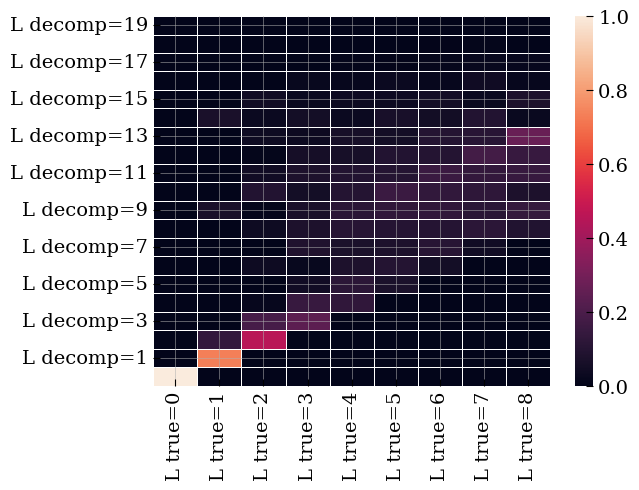

In [34]:
## build an array storing the normalized counts of L_decomp occuring for L_true
L_true_counter = Counter(L_true_values)
data = np.zeros((np.max(L_decomp_values) + 1, np.max(L_true_values) + 1))
for k in range(len(L_true_values)):
    j = L_true_values[k]
    i = L_decomp_values[k]
    data[i, j] += 1 / L_true_counter[j]

## assemble the data into a dataframe for plotting
df = pd.DataFrame(
    data=data,
    columns=["L true=%i" % i for i in range(np.max(L_true_values) + 1)],
    index=["L decomp=%i" % i for i in range(np.max(L_decomp_values) + 1)],
)
df = df.iloc[::-1]

## plot
ax = sns.heatmap(df, linewidth=0.5)

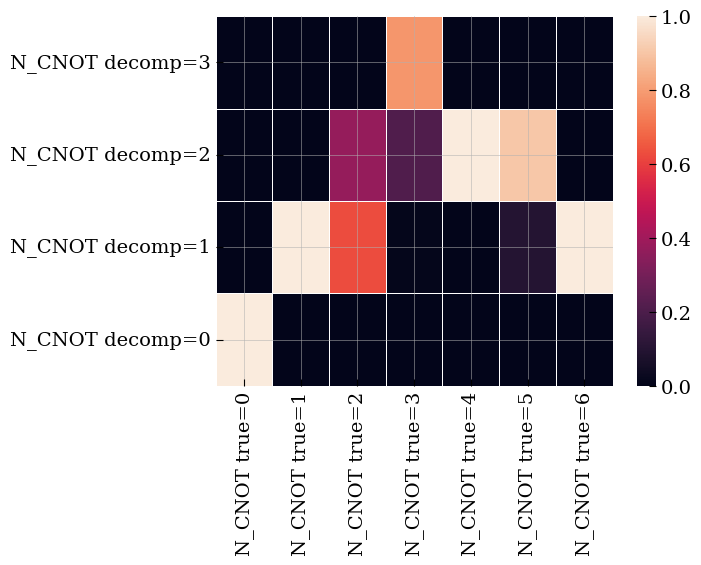

In [35]:
## build an array storing the normalized counts of L_decomp occuring for L_true
N_CNOT_true_counter = Counter(N_CNOT_true_values)

data = np.zeros((np.max(N_CNOT_decomp_values) + 1, np.max(N_CNOT_true_values) + 1))
for k in range(len(N_CNOT_true_values)):
    j = N_CNOT_true_values[k]
    i = N_CNOT_decomp_values[k]
    data[i, j] += 1 / N_CNOT_true_counter[j]

## assemble the data into a dataframe for plotting
df = pd.DataFrame(
    data=data,
    columns=["N_CNOT true=%i" % i for i in range(np.max(N_CNOT_true_values) + 1)],
    index=["N_CNOT decomp=%i" % i for i in range(np.max(N_CNOT_decomp_values) + 1)],
)
df = df.iloc[::-1]

## plot
ax = sns.heatmap(df, linewidth=0.5)